# Neural Networks to Identify Handwritten Digits 
## Gary Lawson - 26 March 2019

## Introduction

The MINST dataset is comprised of thousands of images of handwritten digits ranging from 0 to 9.  Training a data model on labeled data can provide for prediction of future handwritten digits never seen by the model, allowing computer imaging to reduce the need for human interaction in detemining these handwritten characters.  In this experiement, each image is composed of 748 pixel darkeness values aranged in a 28 x 28 matrix of pixels.  Each pixel in the matrix is a feature of its own with a darkness value of 0 to 255, where 0 is white and 255 is black.  The data for this experiment was downloaded from the Kaggle competition named *Digit Recognizer* (link below), and was provided as separate train and test .csv files.

https://www.kaggle.com/c/digit-recognizer/data

The goal of this exercise is to create a neural network experiment design that tests a minimum of two separate experimental factors to identify the best performing model.  The experiments will be evaluated on processing time and the accuracy of both training cross-validation and test predictions.  The results of each design will be submitted to the *Digit Recognizer* Kaggle competition for scoring.    

Python will be used in a Jupyter Notebook to explore the data and produce a series of graphical representations to help visualize the survey data as well as develop several models for evaluation. Tensorflow and Keras will be used to generate the neural networks.  

## Initial EDA

In [1]:
# Seed value for random number generators to obtain reproducible results
RANDOM_SEED = 1

In [2]:
# Import base packages into the namespace for this program
import numpy as np # for creating and working with arrays
import pandas as pd # for creating and working with dataframes
from math import sqrt  # for root mean-squared error calculation
import time # for recording times on model runs

# Modeling routines from Scikit Learn packages
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report # metrics for evaluating models
from sklearn.preprocessing import StandardScaler, MinMaxScaler # data scaling packages
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, \
                                    KFold, RandomizedSearchCV, GridSearchCV # model selection packages

# Import plotting packages
import matplotlib.pyplot as plt  # static plotting
import matplotlib as mpl
%matplotlib inline

# Import other packages
import pickle  # used for dumping and loading binary files
from collections import OrderedDict  # for creating table output

# Import Tensorflow neural network model packages
import tensorflow as tf
#from tensorflow_graph_in_jupyter import show_graph

# Import Keras neural network model package
from tensorflow.keras import layers

print('All packages have been sucessfully imported.')

All packages have been sucessfully imported.


In [3]:
# Read MNIST data train and test data, creating dataframes for both.
train_import = pd.read_csv('train.csv')
test_import = pd.read_csv('test.csv')
print('Data imports successful.')

Data imports successful.


In [4]:
# Check the pandas DataFrame object train_import
print('\nFeature List (including target variable(s)): \n', train_import.columns)
print('\nNumber of Features (including target variable(s): ', len(train_import.columns))
print('\nDataFrame (first five rows):')
train_import.head()


Feature List (including target variable(s)): 
 Index(['label', 'pixel0', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5',
       'pixel6', 'pixel7', 'pixel8',
       ...
       'pixel774', 'pixel775', 'pixel776', 'pixel777', 'pixel778', 'pixel779',
       'pixel780', 'pixel781', 'pixel782', 'pixel783'],
      dtype='object', length=785)

Number of Features (including target variable(s):  785

DataFrame (first five rows):


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### <font color='blue'>Table 1: First Five Rows of Train Data</font>

Table 1 shows that there are 785 columns provided in the dataset that represent the 784 features and 1 target variable.  This aligns with what is expected from the *Digit Recognizer* Kaggle Competition description.  Additionally, each feature column is labeled as "pixelX" where X refers to the pixel number.

In [5]:
# Look at general information about the training data
print('\nGeneral description of the DataFrame:')
print(train_import.info())


General description of the DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB
None


There are 42,000 observations in the dataset, each having 785 features.  All data types are int64, meaning they are 64-bit integers.  The memory usage is 251.5 MB, which appears larger than other datasets I have worked with in the past.  This suggests that the time for computation may be slower than I have seen in the past.

In [6]:
# Check to see if there are any null values in the dataset.
print('\nMax number of values per training dataset feature that are NaN:', train_import.isnull().sum().max())
print('\nMax number of values per test dataset feature that are NaN:', test_import.isnull().sum().max())


Max number of values per training dataset feature that are NaN: 0

Max number of values per test dataset feature that are NaN: 0


Because the max summed value of NaN values is zero, this indicates that there are zero null values in the training and test datasets and it can be assumed that both datasets are complete.

In [7]:
# Look at the descriptive statistics of the data.
print('\nDescriptive statistics of the DataFrame:')
train_import.describe()


Descriptive statistics of the DataFrame:


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,42000.000000,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,...,42000.000000,42000.000000,42000.000000,42000.00000,42000.000000,42000.000000,42000.0,42000.0,42000.0,42000.0
mean,4.456643,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.219286,0.117095,0.059024,0.02019,0.017238,0.002857,0.0,0.0,0.0,0.0
std,2.887730,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.312890,4.633819,3.274488,1.75987,1.894498,0.414264,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,4.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
75%,7.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
max,9.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,254.000000,254.000000,253.000000,253.00000,254.000000,62.000000,0.0,0.0,0.0,0.0


#### <font color='blue'>Table 2: Descriptive Statistics of Train Data</font>

Due to the number of features, Table 2 is hard to review manually.  What we can say from the snapshot shown above is that for the label feature the mean is about 4.5.  This is expected as the numbers range from 0 to 9 (confirmed by the min and max in Table 2), and this suggests that there is an even distribution of target variables.  To confirm the distribution of label values, below is a count of each value category.  This distribution is pretty similar with 5 having the minimum number of target variables and 1 having the largest number of variables.

In [8]:
# Look at the distribution of digits in the train data.
num_count = train_import['label'].value_counts().sort_index()
print(num_count)
print('\nMax: ', num_count.nlargest(1))
print('\nMin: ', num_count.nsmallest(1))

0    4132
1    4684
2    4177
3    4351
4    4072
5    3795
6    4137
7    4401
8    4063
9    4188
Name: label, dtype: int64

Max:  1    4684
Name: label, dtype: int64

Min:  5    3795
Name: label, dtype: int64


## Create a Test and Train Set

In [9]:
# Train data, both X and y are provided.
X_train = train_import.drop(columns=['label']) # Drop label feature from dataset
y_train = train_import['label']

# Test data, note that no y_test exists because it is unknown.
X_test = test_import

In [10]:
# Review the shape of the data
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)

(42000, 784)
(42000,)
(28000, 784)


## Look at Digit Examples

Let's plot some example images.  Functions were defined so that we can look at these images again in the future.

In [11]:
# Plot a single digit specified by specific .iloc
def plot_digit(data):
    image = data.values.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

In [12]:
# Plot first example of 0 through 9
def plot_digit_w_label(data, digit):
    print('\nLabeled value', digit)
    idx_loc = data[data['label']==digit].index[0]
    coords = data.iloc[idx_loc]
    some_digit = coords[1:]
    some_digit_image = some_digit.values.reshape(28, 28)
    plt.imshow(some_digit_image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

    plt.show()

In [13]:
# Plot several digits
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

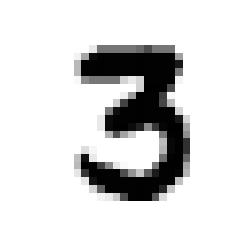

In [14]:
# Plot a single random digit
plot_digit(X_train.loc[3600])

#### <font color='blue'>Figure 1: An example of a single digit from the training dataset</font>


Labeled value 0


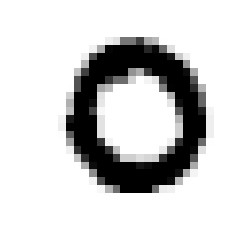


Labeled value 1


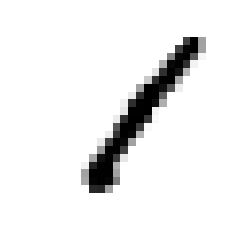


Labeled value 2


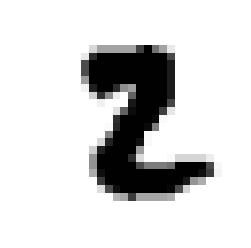


Labeled value 3


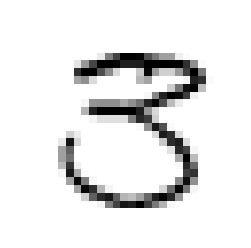


Labeled value 4


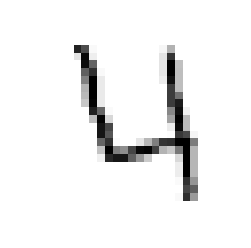


Labeled value 5


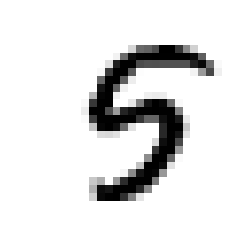


Labeled value 6


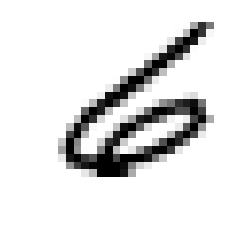


Labeled value 7


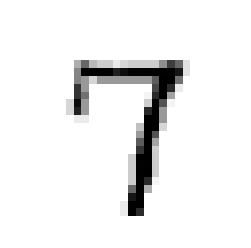


Labeled value 8


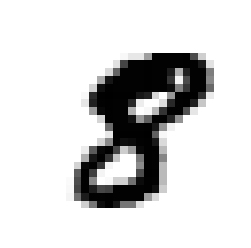


Labeled value 9


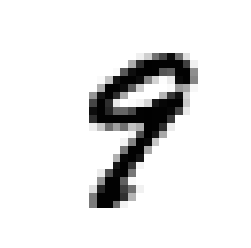

In [15]:
# Plot an example of each digit
for num in range(0,10):
    plot_digit_w_label(train_import,num)

#### <font color='blue'>Figure 2: Examples of each digit</font>

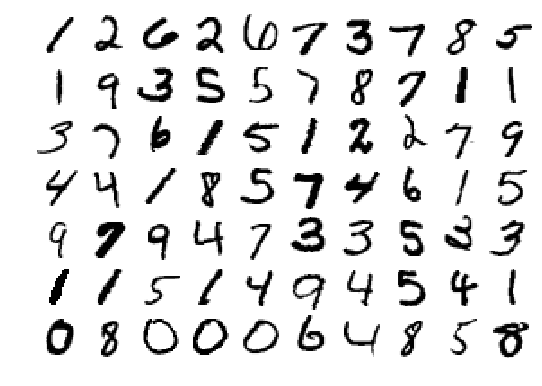

In [16]:
# Randomly plot a selection of digits.
plt.figure(figsize=(9,9))
example_images = np.r_[X_train[:12000:600], X_train[13000:30600:600], X_train[30600:60000:590]]
plot_digits(example_images, images_per_row=10)
#save_fig("more_digits_plot")
plt.show()

#### <font color='blue'>Figure 3: More examples of the digit images contained in the training dataset</font>

## Transformations

No transformations were completed for this exercise.

## Scaling and Normalization

Machine Learning algorithms typically require input data to be normalized to help create efficiencies in the time it takes to train the data.  This is because when using Gradient Descent, the algorithm is able to train the data a lot faster with making incrimental steps between 0 and 1 than it can on a larger scale.  This also puts all input vectors on a common scale for use in the algorithm.

While there are several ways to do this, I have selected using the MinMaxScaler() from Scikit-Learn.  Note that I have fit the scaler to the training dataset and then transformed the training and test dataset separately.  This is to prevent the model from infering information about the test data prior to actually seeing the data.

It is interesting to note that while it perfectly scales the training data as expected, the test data has at least one datapoint that falls very far outside of the 0-1 fitted range with a value of 226.  I am assuming this is due to one (or potentially a few) dark pixel(s) that exists in probably one test dataset image in a position where the training dataset only has very light pixels.  I would guess it is most likely an outlier in the test dataset.

Other methods to use are the StandardScaler() or simply dividing each pixel by the max value of 255.  I chose not to use the StandardScaler() because it resulted in some large values in both the training and test datasets and was not providing very good results on an initial run of a deep neural network.  The approach of dividing the pixels by 255 was a simple and easy approach, but I chose to use the MinMaxScaler instead.

In [17]:
# Create the scaler
scaler = MinMaxScaler()

In [18]:
# Fit the scaler to the training data
scaler.fit(X_train)

C:\Users\DELL\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


MinMaxScaler(copy=True, feature_range=(0, 1))

In [19]:
# Transform data
X_train_scaled = scaler.transform(X_train)
# Print dataset properties before and after scaling
print("Transformed shape: {}".format(X_train_scaled.shape))
print("Dataframe minimum of per-feature values before scaling:\n {}".format((X_train.min()).min()))
print("Dataframe maximum of per-feature values before scaling:\n {}".format((X_train.max()).max()))
print("Dataframe minimum of per-feature values after scaling:\n {}".format((X_train_scaled.min()).min()))
print("Dataframe maximum of per-feature values after scaling:\n {}".format((X_train_scaled.max()).max()))
#print("per-feature minimum before scaling:\n {}".format(X_train.min(axis=0)))
#print("per-feature maximum before scaling:\n {}".format(X_train.max(axis=0)))
#print("per-feature minimum after scaling:\n {}".format(X_train_scaled.min(axis=0)))
#print("per-feature maximum after scaling:\n {}".format(X_train_scaled.max(axis=0)))

Transformed shape: (42000, 784)
Dataframe minimum of per-feature values before scaling:
 0
Dataframe maximum of per-feature values before scaling:
 255
Dataframe minimum of per-feature values after scaling:
 0.0
Dataframe maximum of per-feature values after scaling:
 1.0


In [20]:
# Check the parameters of the scaler
scaler.get_params

<bound method BaseEstimator.get_params of MinMaxScaler(copy=True, feature_range=(0, 1))>

In [21]:
# Transform test data
X_test_scaled = scaler.transform(X_test)
print("Transformed shape: {}".format(X_test_scaled.shape))
# Print test data properties before and after scaling
print("Dataframe minimum of per-feature values after scaling:\n {}".format((X_test.min()).min()))
print("Dataframe maximum of per-feature values after scaling:\n {}".format((X_test.max()).max()))
print("Dataframe minimum of per-feature values after scaling:\n {}".format((X_test_scaled.min()).min()))
print("Dataframe maximum of per-feature values after scaling:\n {}".format(X_test_scaled.max()))
#print("per-feature minimum after scaling:\n{}".format(X_test_scaled.min(axis=0)))
#print("per-feature maximum after scaling:\n{}".format(X_test_scaled.max(axis=0)))

Transformed shape: (28000, 784)
Dataframe minimum of per-feature values after scaling:
 0
Dataframe maximum of per-feature values after scaling:
 255
Dataframe minimum of per-feature values after scaling:
 0.0
Dataframe maximum of per-feature values after scaling:
 226.0


## Create Train and Validation Data Sets

To create use cross validation to train a model, a validation dataset must be created from the training set.  A validation set is a sub dataset made up of observations from the training set, including the features and the target response variable.  This validation set is not used during the training of the model, but is used to validate the results of the model after training by predicting the target response of the unseen validation data and then comparing those predictions to the actual validation target response.  This allows the researcher to evalute the model's ability to generalize to new observations.

To optimize the split of the existing training data set into a new training and validaiton set, a several split sizes will be looped through a simple neural network.  This split size yielding the best results on this simple network will be assumed to represent the optimal split for future neural networks.

### Evaluate Optimal Train/Test Split

In [22]:
# Define test sizes
test_size = [0.05,0.1,0.15,0.2,0.25,0.3] # validation set sizes to try, where the size is a ratio
                                         # of the training set size.

In [23]:
# Create lists to record the results of each iteration
index_for_method = 0 
training_performance_results = []
validation_performance_results = []
processing_time = []

In [24]:
# Create a loop to go through and evaluate a basic model based on several different validation set sizes.
for size in test_size:
    print('\n------------------------------------')
    print('\nValidation Dataset Size Ratio to Training Set:', size)
    
    start_time = time.clock() # start timer to evaluate how long it takes to train this base model
    
    X = X_train_scaled # define the X variables
    y = y_train # define the response variable

    
    X_train_eval, X_valid_eval, y_train_eval, y_valid_eval = train_test_split(X, y, test_size=size, \
                                                                              random_state=RANDOM_SEED) # split data
                                                                                                        # and return arrays
    X_train_eval = X_train_eval.astype(np.float32).reshape(-1, 28*28) # turn to float and resize 
    X_valid_eval = X_valid_eval.astype(np.float32).reshape(-1, 28*28) # turn to float and resize 
    y_train_eval = y_train_eval.astype(np.int32).values # turn to int
    y_valid_eval = y_valid_eval.astype(np.int32).values # turn to int
    
    tf.set_random_seed(RANDOM_SEED)
    
    # Create the model
    feature_cols = [tf.feature_column.numeric_column("X", shape=[28 * 28])]
    dnn_clf = tf.estimator.DNNClassifier(hidden_units=[300,100], n_classes=10,
                                         feature_columns=feature_cols) # create DNN classifier
    
    tf.logging.set_verbosity(tf.logging.WARN) # surpress progress report, only show warnings.  This was added
                                            # to increase usability when uploaded to GitHub.

    # Train the model
    input_fn = tf.estimator.inputs.numpy_input_fn(
        x={"X": X_train_eval}, y=y_train_eval, num_epochs=40, batch_size=50, shuffle=True)
    dnn_clf.train(input_fn=input_fn)
    
    end_time = time.clock() # end timer
    runtime = end_time - start_time  # seconds of wall-clock time 
    print("\nProcessing time (seconds): %f" % runtime) # print process time to train model      
    processing_time.append(runtime) # append process time results to list for comparison table
 
    # Use training and validation data to check model results
    train_input_fn = tf.estimator.inputs.numpy_input_fn(
        x={"X": X_train_eval}, y=y_train_eval, shuffle=False)
    train_eval_results = dnn_clf.evaluate(input_fn=train_input_fn) # training results
    
    valid_input_fn = tf.estimator.inputs.numpy_input_fn(
        x={"X": X_valid_eval}, y=y_valid_eval, shuffle=False)
    valid_eval_results = dnn_clf.evaluate(input_fn=valid_input_fn) # validation results
      
    
    # mean accuracy of prediction in training set
    training_performance = train_eval_results['accuracy']
    print("\nTraining set accuracy: %f" % training_performance)
    training_performance_results.append(training_performance) # append results to list for comparison table

    # mean accuracy of prediction in test set
    validation_performance = valid_eval_results['accuracy']
    print("\nValidation set accuracy: %f" % validation_performance)
    validation_performance_results.append(validation_performance) # append results to list for comparison table
                
    index_for_method += 1


------------------------------------

Validation Dataset Size Ratio to Training Set: 0.05
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\DELL\\AppData\\Local\\Temp\\tmpl5cmor3l', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001EE2FA9F470>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
Instructions

In [25]:
# Create a table to display results of experiement
results = pd.DataFrame(OrderedDict([('Validation Dataset Ratio', test_size),
                        ('Processing Time', processing_time),
                        ('Training Set Accuracy', training_performance_results),
                        ('Validation Set Accuracy', validation_performance_results)]))

print('\nValidation Dataset Size Ratio to Training Dataset: Tensorflow Deep Neural Networks\n')
results 


Validation Dataset Size Ratio to Training Dataset: Tensorflow Deep Neural Networks



,Validation Dataset Ratio,Processing Time,Training Set Accuracy,Validation Set Accuracy
0,0.05,71.529354,1.0,0.970476
1,0.10,64.895221,1.0,0.973571
2,0.15,61.044106,1.0,0.973810
3,0.20,57.973283,1.0,0.977143
4,0.25,54.685335,1.0,0.974667
5,0.30,51.519984,1.0,0.975397


#### <font color='blue'>Table 3: Validation Dataset Size Ratio to Training Dataset: Tensorflow Deep Neural Networks</font>

According to the results in Table 3 of this experiment, we can see that the validation dataset size of 20% of the entire training dataset may be optimal.  This may be trivial, as there does not seem to be a significant difference in the validation dataset size.

### Create Training and Validation Test Set for Modeling Based on Optimial Size

Using the results from the previous experiement, an optimal training/validation dataset split can now be created.  Below, a training set and validation set are created to use in the development of models. Note that reshaping the data into an array with float data types is necessary for feeding it into Tensorflow.  Below I take the normalized data and break it into a test and validation set for use in training a neural network.

In [26]:
X = X_train_scaled # define the training X variables
y = y_train # define the training response variable

opt_test_size = 0.2 # optimal test size from previous experiment
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=opt_test_size, random_state=RANDOM_SEED) # split data
                                                                                                     # and return arrays
X_train = X_train.astype(np.float32).reshape(-1, 28*28) # turn to float and resize 
X_valid = X_valid.astype(np.float32).reshape(-1, 28*28) # turn to float and resize 
y_train = y_train.astype(np.int32).values # turn to int 
y_valid = y_valid.astype(np.int32).values # turn to int 

X_test = X_test_scaled # define the test X variable (response variable unknown)

In [27]:
# Check the shape of all arrays
print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)
print(X_test.shape)

(33600, 784)
(33600,)
(8400, 784)
(8400,)
(28000, 784)


Now that good normalized training and validation datasets have been created to use in Tensorflow deep neural networks, it was decided the data should be pickled so that it can be saved for use again at a later point if needed.  This is valuable because all of the previous code can be avoided in future testing.

In [28]:
# Define collection of objects to export as binary file using pickle.
data = {
    'X_train': X_train,
    'y_train': y_train,
    'X_valid': X_valid,
    'y_valid': y_valid,
    'X_test': X_test}

# Write to binary file
with open('mnist_data_GitHub_Version.pickle', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)

print('\n Run complete. data objects sent to binary file  mnist_data.pickle')


 Run complete. data objects sent to binary file  mnist_data.pickle


In [29]:
# Extract objects from the dictionary object data
X_train = data['X_train']
y_train = data['y_train'] 
X_valid = data['X_valid'] 
y_valid = data['y_valid'] 
X_test = data['X_test'] 

## Create Models

Tensorflow will be used to develop a deep neural network (DNN) for the MNIST data set.  A neural network is simply a composite function that accepts inputs and calculates one or more outputs.  Where a DNN differs from other machine learning models is that the structure of the composite function is modeled after the human brain.  The basic concept is that the model accepts inputs to the model, and then passes these inputs through a series of interconnected nodes.  Using response variables to test which nodes were activiated with any particular combination of inputs, and then adjusting each node's activiation criteria to better fit the anticipated response is what makes these DNNs so powerful when it comes to learning.

Let's break down the structure of DNN a bit more.  A DNN model starts out with a defined data input layer that has an individual input node for each input. This input layer is then fully connected to at least one hidden layer, which is a separate layer of nodes, each of which is connected to every single node in the input layer.  Additionally, each node in this hidden layer is connected to each node in the following layer.  Each additional hidden layer follows this same format so that all nodes in a layer are connected to all nodes in the previous layer and all nodes in the following layer.  Last, an output layer is created to produce a result from the DNN.  As you may guess, this layer had individual nodes for each possible output that are connected to each node in the previous layer.  Figure 4 from Suryansh (2018) shows a graphical represenation of a neural network.  This figure clearly shows the input layer that has 8 separate inputs, 3 hidden layers each having 9 nodes, and the output layer that has 4 possible responses.

References: Suryansh S. (2018, April 7). Neural Networks: All YOU Need to Know. Retrieved from https://towardsdatascience.com/nns-aynk-c34efe37f15a

![](DNNs_MNIST_GLAWSON_Fig1.png)

#### <font color='blue'>Figure 4: Example of a Deep Neural Network</font>

Without getting to deep into the mathematics behind DNNs, the general idea is that each hidden layer node has a connection weight that tells a node when to activate.  In training, the network uses these weights to activate specific neuron pathways that result in a specific predicted output.  This predicted output is then compared to a known output, and the model generates a bias on how it "thinks" it should update the weights to better represent the actual known outputs.  It then back propogates these bias values, slightly changing the connection weights.  A series of iterations of backpropogation can be complete to let the DNN learn over several groupings of data what connection weights best represent the desired output.

While Tensorflow can be used on its own, I have chosen to use the Scikit-Learn API that uses Tensorflow in the background to help streamline the development and training of the models.  While it appears this method is a bit more limited than building the graphs and models manually using Tensorflow, this may not be a bad thing as I am only looking to tweak a few of the many hyperparameters.

### Model 1 - Tensorflow Neural Network Using Scikit-Learn
### Inspect How Layers and Nodes Impact Model

The intent of this model is to create a factoral design to compare how different numbers of layers and nodes will impact the model.  The layer, also called a hidden layer, can be visualized as a mathematical way to begin breaking down the input data to look for patterns.  When more layers are added, it can be thought of as progressively combining prevously identified patterns and looking for new, more complex patterns or combinations of patterns.  For example, if the first hidden layer identified edges like straight lines of dark pixels in the images that are fed into the model, the second hidden layer may begin to look at patterns of how these edges come together to make shapes such as circles or curved lines.  Nodes or neurons are the point where a specific pattern is consistantly found, and when found in the future, this neuron will activate.  Activiation of a specific neuron causes a chain reaction of activiations in connected neurons in following layers.  Each time a specific pattern is found during training, the weights associated with the neuron connections is learned and reinforced so that future recognition of the same pattern will activate the same chain of neurons, theoretically resulting in an accurate output prediction.

The number of layers in this experiment will include 2, 3, and 5.  These values were selected so allow for the model to increase in it's complexity as more layers are added in.  The number of nodes in each layer ranges from 100 nodes to 600 nodes, which were selected arbitrarily to span across a wide range that stayed between the number of input nodes and the number of output nodes.  The type of node structure in each layer was also tested to determine if a constant number of nodes in every layer (documented as a "Constant" layer) would perform better than a design where each layer has a decreasing number of nodes (documented as a "Funnel" layer.  

In [30]:
# Create names for each iteration of the model
names = ['2-Layers-300-Node-Max-per-Layer-Funnel',
         '2-Layers-600-Node-Max-per-Layer-Funnel',
         '2-Layers-100-Node-Max-per-Layer-Constant',
         '2-Layers-300-Node-Max-per-Layer-Constant',
         '3-Layers-300-Node-Max-per-Layer-Funnel',
         '3-Layers-600-Node-Max-per-Layer-Funnel',
         '3-Layers-100-Node-Max-per-Layer-Constant',
         '3-Layers-300-Node-Max-per-Layer-Constant',
         '5-Layers-300-Node-Max-per-Layer-Funnel',
         '5-Layers-600-Node-Max-per-Layer-Funnel',
         '5-Layers-100-Node-Max-per-Layer-Constant',
         '5-Layers-300-Node-Max-per-Layer-Constant']

In [31]:
# Define the layers for each iteration of the model
Layers = [2, 2, 2, 2, 3, 3, 3, 3, 5, 5, 5, 5]

In [32]:
# Define the max number of nodes for each iteration of the model.  
# This is just informational for the comparison table.
max_nodes_per_layer = [300, 600, 100, 300, 300, 600, 100, 300, 300, 600, 100, 300]

In [33]:
# Define the number of layers and number of nodes per layer for each iteration of the model.
layer1 = [300,100]
layer2 = [600,300]
layer3 = [100,100]
layer4 = [300,300]
layer5 = [300,200,100]
layer6 = [600,300,100]
layer7 = [100,100,100]
layer8 = [300,300,300]
layer9 = [300,250,200,150,100]
layer10 = [600,500,400,300,200]
layer11 = [100,100,100,100,100]
layer12 = [300,300,300,300,300]

In [34]:
# Create a list of the layers to use in each iteration
hidden_unit_items = [layer1, layer2, layer3, layer4, layer5, layer6, layer7, layer8, layer9, layer10, layer11, layer12]
type(hidden_unit_items)
hidden_unit_items

[[300, 100],
 [600, 300],
 [100, 100],
 [300, 300],
 [300, 200, 100],
 [600, 300, 100],
 [100, 100, 100],
 [300, 300, 300],
 [300, 250, 200, 150, 100],
 [600, 500, 400, 300, 200],
 [100, 100, 100, 100, 100],
 [300, 300, 300, 300, 300]]

In [35]:
# Create lists to hold the results of each iteration.
index_for_method = 0 
training_performance_results = []
validation_performance_results = []
processing_time = []

In [36]:
for name, unit in zip(names, hidden_unit_items):
    print('\n------------------------------------')
    print('\nMethod:', name)
    print('\n  Specification of method:', unit)
    
    start_time = time.clock() # start timer to evaluate how long it takes to train this base model
    
    tf.set_random_seed(RANDOM_SEED)
    
    # Create the model
    feature_cols = [tf.feature_column.numeric_column("X", shape=[28 * 28])]
    dnn_clf = tf.estimator.DNNClassifier(hidden_units=unit, n_classes=10,
                                         feature_columns=feature_cols) # create DNN classifier

    tf.logging.set_verbosity(tf.logging.WARN) # surpress progress report, only show warnings.  This was added
                                        # to increase usability when uploaded to GitHub.
            
    # Train the model
    input_fn = tf.estimator.inputs.numpy_input_fn(
        x={"X": X_train}, y=y_train, num_epochs=40, batch_size=50, shuffle=True)
    dnn_clf.train(input_fn=input_fn)
    
    end_time = time.clock() # end timer
    runtime = end_time - start_time  # seconds of wall-clock time 
    print("\nProcessing time (seconds): %f" % runtime)  # print process time to train model        
    processing_time.append(runtime) # append process time results to list for comparison table
    
    # Evaluate the model
    train_input_fn = tf.estimator.inputs.numpy_input_fn(
        x={"X": X_train}, y=y_train, shuffle=False)
    train_eval_results = dnn_clf.evaluate(input_fn=train_input_fn) # training results
    
    valid_input_fn = tf.estimator.inputs.numpy_input_fn(
        x={"X": X_valid}, y=y_valid, shuffle=False)
    valid_eval_results = dnn_clf.evaluate(input_fn=valid_input_fn) # validation results
        
    
    # mean accuracy of prediction in training set
    training_performance = train_eval_results['accuracy']
    print("\nTraining set accuracy: %f" % training_performance)
    training_performance_results.append(training_performance) # append results to list for comparison table

    # mean accuracy of prediction in validation set
    validation_performance = valid_eval_results['accuracy']
    print("\nValidation set accuracy: %f" % validation_performance)
    validation_performance_results.append(validation_performance) # append results to list for comparison table
                
    index_for_method += 1


------------------------------------

Method: 2-Layers-300-Node-Max-per-Layer-Funnel

  Specification of method: [300, 100]

Processing time (seconds): 57.708598

Training set accuracy: 1.000000

Validation set accuracy: 0.975595

------------------------------------

Method: 2-Layers-600-Node-Max-per-Layer-Funnel

  Specification of method: [600, 300]

Processing time (seconds): 121.792811

Training set accuracy: 1.000000

Validation set accuracy: 0.977381

------------------------------------

Method: 2-Layers-100-Node-Max-per-Layer-Constant

  Specification of method: [100, 100]

Processing time (seconds): 40.963498

Training set accuracy: 0.999970

Validation set accuracy: 0.972738

------------------------------------

Method: 2-Layers-300-Node-Max-per-Layer-Constant

  Specification of method: [300, 300]

Processing time (seconds): 67.497696

Training set accuracy: 1.000000

Validation set accuracy: 0.973214

------------------------------------

Method: 3-Layers-300-Node-Max-pe

In [37]:
# Create a table to display results of this experiment
results = pd.DataFrame(OrderedDict([('Method Name', names),
                        ('Layers', Layers),
                        ('Max Nodes per Layer', max_nodes_per_layer),
                        ('Processing Time', processing_time),
                        ('Training Set Accuracy', training_performance_results),
                        ('Validation Set Accuracy', validation_performance_results)]))

print('\nBenchmark Experiment: Tensorflow Deep Neural Networks\n')
results 


Benchmark Experiment: Tensorflow Deep Neural Networks



,Method Name,Layers,Max Nodes per Layer,Processing Time,Training Set Accuracy,Validation Set Accuracy
0,2-Layers-300-Node-Max-per-Layer-Funnel,2,300,57.708598,1.00000,0.975595
1,2-Layers-600-Node-Max-per-Layer-Funnel,2,600,121.792811,1.00000,0.977381
2,2-Layers-100-Node-Max-per-Layer-Constant,2,100,40.963498,0.99997,0.972738
3,2-Layers-300-Node-Max-per-Layer-Constant,2,300,67.497696,1.00000,0.973214
4,3-Layers-300-Node-Max-per-Layer-Funnel,3,300,69.825244,1.00000,0.975595
5,3-Layers-600-Node-Max-per-Layer-Funnel,3,600,128.524423,1.00000,0.974762
6,3-Layers-100-Node-Max-per-Layer-Constant,3,100,46.491012,1.00000,0.969643
7,3-Layers-300-Node-Max-per-Layer-Constant,3,300,84.511638,1.00000,0.972619
8,5-Layers-300-Node-Max-per-Layer-Funnel,5,300,92.978005,1.00000,0.975238
9,5-Layers-600-Node-Max-per-Layer-Funnel,5,600,222.417990,1.00000,0.970238


#### <font color='blue'>Table 5: Benchmark Experiment: Tensorflow Deep Neural Networks</font>

In this experiment a loop was used to try several different combinations of number of layers and nodes to find the opitmal structure.  Table 4 suggests that two layers in the deep neural network (DNN) provides the best accuracy when using the validation data as the decision factor, as all four tests with two layers resulted in strong validation scores typically 0.970 or greater. There is no strong reason to increase the number of layers any further as the three layer and five layer models perform slighly worse and can begin to take more time to train.  Additionally, the larger number of nodes appears to be beneficial, as the model with 2 layers and 600 node maximum per layer edges out the model with 2 layers and 300 node maximum per layer.  Last, the funnel approach to layers appears to provide the best model predictions.  While slightly on the longer side of training time (but certainly not the maximum model training time), the 2-Layers-600-Node-Max-per_Layer-Funnel model appears to be the best predictor when using accuracy of the validation set predictions as an indicator.

### Model 2 - Tensorflow Neural Network Using Scikit-Learn
### Fine Tune Number of Layers and Nodes

Using the results from the previous experiements, this model will continue to fine tune the DNN model.  Specifically, a 2-layer DNN will be developed to optimize the validation predictions.  The step in the node funnel size will be evaluated further to find an optimal model design.

In [38]:
# Create names for each iteration of the model
names = ['2-Layers-600-Node-Max-per-Layer-50-Step-Funnel',
         '2-Layers-600-Node-Max-per-Layer-100-Step-Funnel',
         '2-Layers-600-Node-Max-per-Layer-200-Step-Funnel',
         '2-Layers-600-Node-Max-per-Layer-300-Step-Funnel',
         '2-Layers-600-Node-Max-per-Layer-400-Step-Funnel',
         '2-Layers-600-Node-Max-per-Layer-500-Step-Funnel',
         '2-Layers-700-Node-Max-per-Layer-50-Step-Funnel',
         '2-Layers-700-Node-Max-per-Layer-100-Step-Funnel',
         '2-Layers-700-Node-Max-per-Layer-200-Step-Funnel',
         '2-Layers-700-Node-Max-per-Layer-300-Step-Funnel',
         '2-Layers-700-Node-Max-per-Layer-400-Step-Funnel',
         '2-Layers-700-Node-Max-per-Layer-500-Step-Funnel']

In [39]:
# Define the layers for each iteration of the model
Layers = [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]

In [40]:
# Define the max number of nodes for each iteration of the model.  
# This is just informational for the comparison table.
max_nodes_per_layer = [600, 600, 600, 600, 600, 600, 700, 700, 700, 700, 700, 700]

In [41]:
# Define the number of layers and number of nodes per layer for each iteration of the model.
layer1 = [600,550]
layer2 = [600,500]
layer3 = [600,400]
layer4 = [600,300]
layer5 = [600,200]
layer6 = [600,100]
layer7 = [700,650]
layer8 = [700,600]
layer9 = [700,500]
layer10 = [700,400]
layer11 = [700,300]
layer12 = [700,200]

In [42]:
# Create a list of the layers to use in each iteration
hidden_unit_items = [layer1, layer2, layer3, layer4, layer5, layer6, layer7, layer8,
                     layer9, layer10, layer11, layer12]
type(hidden_unit_items)
hidden_unit_items

[[600, 550],
 [600, 500],
 [600, 400],
 [600, 300],
 [600, 200],
 [600, 100],
 [700, 650],
 [700, 600],
 [700, 500],
 [700, 400],
 [700, 300],
 [700, 200]]

In [43]:
# Create lists to hold the results of each iteration.
index_for_method = 0 
training_performance_results = []
validation_performance_results = []
processing_time = []

In [44]:
for name, unit in zip(names, hidden_unit_items):
    print('\n------------------------------------')
    print('\nMethod:', name)
    print('\n  Specification of method:', unit)
    start_time = time.clock()
    
    tf.set_random_seed(RANDOM_SEED)
    feature_cols = [tf.feature_column.numeric_column("X", shape=[28 * 28])]
    dnn_clf = tf.estimator.DNNClassifier(hidden_units=unit, n_classes=10,
                                         feature_columns=feature_cols)
    
    tf.logging.set_verbosity(tf.logging.WARN) # surpress progress report, only show warnings.  This was added
                                        # to increase usability when uploaded to GitHub.
            
    # Train the model
    input_fn = tf.estimator.inputs.numpy_input_fn(
        x={"X": X_train}, y=y_train, num_epochs=40, batch_size=50, shuffle=True)
    dnn_clf.train(input_fn=input_fn)
    
    end_time = time.clock() # end timer
    runtime = end_time - start_time  # seconds of wall-clock time 
    print("\nProcessing time (seconds): %f" % runtime)  # print process time to train model        
    processing_time.append(runtime) # append process time results to list for comparison table
        
    # Evaluate the model
    train_input_fn = tf.estimator.inputs.numpy_input_fn(
        x={"X": X_train}, y=y_train, shuffle=False)
    train_eval_results = dnn_clf.evaluate(input_fn=train_input_fn) # training results
    
    valid_input_fn = tf.estimator.inputs.numpy_input_fn(
        x={"X": X_valid}, y=y_valid, shuffle=False)
    valid_eval_results = dnn_clf.evaluate(input_fn=valid_input_fn) # validation results
        
    
    # mean accuracy of prediction in training set
    training_performance = train_eval_results['accuracy']
    print("\nTraining set accuracy: %f" % training_performance)
    training_performance_results.append(training_performance) # append results to list for comparison table


    # mean accuracy of prediction in test set
    validation_performance = valid_eval_results['accuracy']
    print("\nValidation set accuracy: %f" % validation_performance)
    validation_performance_results.append(validation_performance) # append results to list for comparison table
                
    index_for_method += 1


------------------------------------

Method: 2-Layers-600-Node-Max-per-Layer-50-Step-Funnel

  Specification of method: [600, 550]

Processing time (seconds): 163.875281

Training set accuracy: 1.000000

Validation set accuracy: 0.975238

------------------------------------

Method: 2-Layers-600-Node-Max-per-Layer-100-Step-Funnel

  Specification of method: [600, 500]

Processing time (seconds): 153.912467

Training set accuracy: 1.000000

Validation set accuracy: 0.977381

------------------------------------

Method: 2-Layers-600-Node-Max-per-Layer-200-Step-Funnel

  Specification of method: [600, 400]

Processing time (seconds): 137.655024

Training set accuracy: 1.000000

Validation set accuracy: 0.975595

------------------------------------

Method: 2-Layers-600-Node-Max-per-Layer-300-Step-Funnel

  Specification of method: [600, 300]

Processing time (seconds): 120.750260

Training set accuracy: 1.000000

Validation set accuracy: 0.976667

------------------------------------

In [45]:
# Create a table to display results of this experiment
results = pd.DataFrame(OrderedDict([('Method Name', names),
                        ('Layers', Layers),
                        ('Max Nodes per Layer', max_nodes_per_layer),
                        ('Processing Time', processing_time),
                        ('Training Set Accuracy', training_performance_results),
                        ('Validation Set Accuracy', validation_performance_results)]))

print('\nFine Tuning of Model: Tensorflow Deep Neural Networks\n')
results 


Fine Tuning of Model: Tensorflow Deep Neural Networks



,Method Name,Layers,Max Nodes per Layer,Processing Time,Training Set Accuracy,Validation Set Accuracy
0,2-Layers-600-Node-Max-per-Layer-50-Step-Funnel,2,600,163.875281,1.0,0.975238
1,2-Layers-600-Node-Max-per-Layer-100-Step-Funnel,2,600,153.912467,1.0,0.977381
2,2-Layers-600-Node-Max-per-Layer-200-Step-Funnel,2,600,137.655024,1.0,0.975595
3,2-Layers-600-Node-Max-per-Layer-300-Step-Funnel,2,600,120.750260,1.0,0.976667
4,2-Layers-600-Node-Max-per-Layer-400-Step-Funnel,2,600,113.476729,1.0,0.976667
5,2-Layers-600-Node-Max-per-Layer-500-Step-Funnel,2,600,104.801969,1.0,0.977143
6,2-Layers-700-Node-Max-per-Layer-50-Step-Funnel,2,700,189.018758,1.0,0.975119
7,2-Layers-700-Node-Max-per-Layer-100-Step-Funnel,2,700,180.718724,1.0,0.975000
8,2-Layers-700-Node-Max-per-Layer-200-Step-Funnel,2,700,169.886834,1.0,0.978810
9,2-Layers-700-Node-Max-per-Layer-300-Step-Funnel,2,700,158.336167,1.0,0.976429


#### <font color='blue'>Table 5: Fine Tuning of Model: Tensorflow Deep Neural Networks</font>

This experiment used a loop was used to test several different step sizes between two layers to see how this impacts the model. It is clear from Table 5 that the model with the best score is one with 2-layers designed as a funnel with 600 nodes in the first layer and 100 nodes in the second layer.  This is the design that will be used going forward as the optimal model identified so far.

### Model 3 - Tensorflow Neural Network Using Scikit-Learn
### Test How Epoch Number Impacts Model

Now that an good model has been developed in the previous two experiements, the intent of this model is to create a factoral design to evaluate how the number of epochs impacts the model.  An epoch is a unit of measure that is used to describe the entire dataset that is passed through a neural network model during training.  This means that one epoch is when the entire dataset has been passed forward and backward through the model exactly one time, and node connection weights are adjusted accordingly. This unit of measure is important because when training neural networks, the training dataset is often extremely large and prohibitive to pass through the model all at the same time.  Instead, the training dataset is broken up into batches and fed to the model in smaller groups.  Epochs are the measurement used to keep track of these batches and verify that the model is trained on every training observation.  

When using only one epoch, the model is typically underfit as it has only been given the opporutnity to see the training data once in one particular batch.  Increasing the number of epochs during training essentially means that the model is seeing the entire dataset an increasing number of times, but with each epoch the batches are randomly selected, allowing the model to continually train the weights of each node connection to better fit the data.  When more epochs than necessary are used during training, the model can begin to overfit the data, which will be demonstrated by increasing training accuracies but a sudden decrase in validation accuracies.  Figure 5 from Sharma (2017) shows how a dataset may be impacted by a varying number of epochs.  The left graphic shows overfitting (too many epochs), the middle graphic shows an optimal fit (optimal number of epochs), and the right graphics shows underfitting (too few epochs).

References: Sharma S. (2017, September 23). Epoch vs Batch Size vs Iterations. Retrieved from https://towardsdatascience.com/epoch-vs-iterations-vs-batch-size-4dfb9c7ce9c9

![](DNNs_MNIST_GLAWSON_Fig2.png)

#### <font color='blue'>Figure 5: Impacts of Varying the Number of Epochs</font>

Finding the correct number of epochs is best done through experiementation, as the optimal number will vary with the data and diversity of each dataset.  The 8 epoch values evaluated in this experiment range from 5 to 500.  The first epoch value is relatively low, the next 5 epochs are midrange and have 10-epoch steps, and the last two epoch values will test much larger changes in this hyperparameter.

In [46]:
# Create names for each iteration of the model
names = ['2-Layers-600-Node-Max-per-Layer-Funnel-5-Epochs',
         '2-Layers-600-Node-Max-per-Layer-Funnel-10-Epochs',
         '2-Layers-600-Node-Max-per-Layer-Funnel-20-Epochs',
         '2-Layers-600-Node-Max-per-Layer-Funnel-30-Epochs',
         '2-Layers-600-Node-Max-per-Layer-Funnel-40-Epochs',
         '2-Layers-600-Node-Max-per-Layer-Funnel-50-Epochs',
         '2-Layers-600-Node-Max-per-Layer-Funnel-100-Epochs',
         '2-Layers-600-Node-Max-per-Layer-Funnel-500-Epochs']

In [47]:
# Define the number of epochs for each iteration of the model
epochs = [5,10,20,30,40,50,100,500]

In [48]:
# Define the layers for each iteration of the model
Layers = [2, 2, 2, 2, 2, 2, 2, 2] 

In [49]:
# Define the max number of nodes for each iteration of the model.  
# This is just informational for the comparison table.
max_nodes_per_layer = [600, 600, 600, 600, 600, 600, 600, 600]

In [50]:
# Define the number of layers and number of nodes per layer for each iteration of the model.
layer1 = [600,100]

In [51]:
# Create a list of the layers to use in each iteration
hidden_unit_items = [layer1]
type(hidden_unit_items)
hidden_unit_items

[[600, 100]]

In [52]:
# Create lists to hold the results of each iteration.
index_for_method = 0 
training_performance_results = []
validation_performance_results = []
processing_time = []

In [53]:
for name, epoch in zip(names, epochs):
    print('\n------------------------------------')
    print('\nMethod:', name)
    print('\n  Specification of method:', layer1)
    print('\n  Number of Epochs:', epoch)
    start_time = time.clock()
    
    tf.set_random_seed(RANDOM_SEED)
    feature_cols = [tf.feature_column.numeric_column("X", shape=[28 * 28])]
    dnn_clf = tf.estimator.DNNClassifier(hidden_units=layer1, n_classes=10,
                                         feature_columns=feature_cols)
    
    tf.logging.set_verbosity(tf.logging.WARN) # surpress progress report, only show warnings.  This was added
                                        # to increase usability when uploaded to GitHub.
            
    # Train the model
    input_fn = tf.estimator.inputs.numpy_input_fn(
        x={"X": X_train}, y=y_train, num_epochs=epoch, batch_size=50, shuffle=True)
    dnn_clf.train(input_fn=input_fn)
    
    end_time = time.clock() # end timer
    runtime = end_time - start_time  # seconds of wall-clock time 
    print("\nProcessing time (seconds): %f" % runtime)  # print process time to train model        
    processing_time.append(runtime) # append process time results to list for comparison table
    
    # Evaluate the model 
    train_input_fn = tf.estimator.inputs.numpy_input_fn(
        x={"X": X_train}, y=y_train, shuffle=False)
    train_eval_results = dnn_clf.evaluate(input_fn=train_input_fn) # training results
    
    valid_input_fn = tf.estimator.inputs.numpy_input_fn(
        x={"X": X_valid}, y=y_valid, shuffle=False)
    valid_eval_results = dnn_clf.evaluate(input_fn=valid_input_fn) # validation results
        
    
    # mean accuracy of prediction in training set
    training_performance = train_eval_results['accuracy']
    print("\nTraining set accuracy: %f" % training_performance)
    training_performance_results.append(training_performance) # append results to list for comparison table

    # mean accuracy of prediction in test set
    validation_performance = valid_eval_results['accuracy']
    print("\nValidation set accuracy: %f" % validation_performance)
    validation_performance_results.append(validation_performance) # append results to list for comparison table
                
    index_for_method += 1


------------------------------------

Method: 2-Layers-600-Node-Max-per-Layer-Funnel-5-Epochs

  Specification of method: [600, 100]

  Number of Epochs: 5

Processing time (seconds): 15.220140

Training set accuracy: 0.993810

Validation set accuracy: 0.971310

------------------------------------

Method: 2-Layers-600-Node-Max-per-Layer-Funnel-10-Epochs

  Specification of method: [600, 100]

  Number of Epochs: 10

Processing time (seconds): 28.436096

Training set accuracy: 0.999643

Validation set accuracy: 0.977024

------------------------------------

Method: 2-Layers-600-Node-Max-per-Layer-Funnel-20-Epochs

  Specification of method: [600, 100]

  Number of Epochs: 20

Processing time (seconds): 53.684456

Training set accuracy: 1.000000

Validation set accuracy: 0.979048

------------------------------------

Method: 2-Layers-600-Node-Max-per-Layer-Funnel-30-Epochs

  Specification of method: [600, 100]

  Number of Epochs: 30

Processing time (seconds): 79.477215

Training 

In [54]:
# Create a table to display results of this experiment
results = pd.DataFrame(OrderedDict([('Method Name', names),
                        ('Layers', Layers),
                        ('Max Nodes per Layer', max_nodes_per_layer),
                        ('Processing Time', processing_time),
                        ('Training Set Accuracy', training_performance_results),
                        ('Validation Set Accuracy', validation_performance_results)]))

print('\nEpoch Impact Experiment: Tensorflow Deep Neural Networks\n')
results 


Epoch Impact Experiment: Tensorflow Deep Neural Networks



,Method Name,Layers,Max Nodes per Layer,Processing Time,Training Set Accuracy,Validation Set Accuracy
0,2-Layers-600-Node-Max-per-Layer-Funnel-5-Epochs,2,600,15.220140,0.993810,0.971310
1,2-Layers-600-Node-Max-per-Layer-Funnel-10-Epochs,2,600,28.436096,0.999643,0.977024
2,2-Layers-600-Node-Max-per-Layer-Funnel-20-Epochs,2,600,53.684456,1.000000,0.979048
3,2-Layers-600-Node-Max-per-Layer-Funnel-30-Epochs,2,600,79.477215,1.000000,0.977738
4,2-Layers-600-Node-Max-per-Layer-Funnel-40-Epochs,2,600,103.944204,1.000000,0.979762
5,2-Layers-600-Node-Max-per-Layer-Funnel-50-Epochs,2,600,130.421620,1.000000,0.978214
6,2-Layers-600-Node-Max-per-Layer-Funnel-100-Epochs,2,600,262.079209,1.000000,0.976905
7,2-Layers-600-Node-Max-per-Layer-Funnel-500-Epochs,2,600,1297.400388,1.000000,0.978214


#### <font color='blue'>Table 6: Epoch Impact Experiment: Tensorflow Deep Neural Networks</font>

This experiment used a loop was used to test several different epoch numbers to see how this impacts the model.  It is clear from Table 6 that as more epochs are added, the model takes progressively more time to train.  However, using the accuracy of the validation set predictions as a determining factor, it is evident that more epochs does not always result in better accuracy for unseen data (in this case the validation data).  As has been discussed, too many epochs begins to lead to overfitting of the training data, reducing the ability for the model to generalize.  Using these results, 40 epochs appears to be the optimal value for accuracy and will be used for the final model.

## Model Predictions

Using what has been learned from the previous experiements, the best model identified so far will be used to make test predictions which will be submitted to Kaggle.

In [55]:
# Use the optimal number of layers and nodes to create a final model
tf.set_random_seed(RANDOM_SEED)
feature_cols = [tf.feature_column.numeric_column("X", shape=[28 * 28])]
dnn_clf = tf.estimator.DNNClassifier(hidden_units=[600,100], n_classes=10,
                                     feature_columns=feature_cols)

tf.logging.set_verbosity(tf.logging.WARN) # surpress progress report, only show warnings.  This was added
                                    # to increase usability when uploaded to GitHub.

# Train the model
input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"X": X_train}, y=y_train, num_epochs=40, batch_size=50, shuffle=True)
dnn_clf.train(input_fn=input_fn)

In [56]:
tf.logging.set_verbosity(tf.logging.WARN) # surpress progress report, only show warnings.  This was added
                                    # to increase usability when uploaded to GitHub.
            
# Check the accuracy one more time
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"X": X_train}, y=y_train, shuffle=False)
train_eval_results = dnn_clf.evaluate(input_fn=train_input_fn) # training results

valid_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"X": X_valid}, y=y_valid, shuffle=False)
valid_eval_results = dnn_clf.evaluate(input_fn=valid_input_fn) # validation results


# mean accuracy of prediction in training set
training_performance = train_eval_results['accuracy']
print("\nTraining set accuracy: %f" % training_performance)
training_performance_results.append(training_performance) # append results to list for comparison table

# mean accuracy of prediction in test set
validation_performance = valid_eval_results['accuracy']
print("\nValidation set accuracy: %f" % validation_performance)
validation_performance_results.append(validation_performance) # append results to list for comparison table


Training set accuracy: 1.000000

Validation set accuracy: 0.977857


In [57]:
# Make predictions on the test data
test_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"X": X_test}, shuffle=False)

predictions = list(dnn_clf.predict(input_fn=test_input_fn))
predicted_classes = [p["class_ids"] for p in predictions]
preds = [i[0] for i in predicted_classes]

d = {'Label': preds}
predictions_df = pd.DataFrame(data=d)

np.savetxt('predit_submission.csv', 
                  np.c_[range(1,len(X_test)+1),predictions_df], 
                  delimiter=',', 
                  header = 'ImageId,Label', 
                  comments = '', 
                  fmt='%s')

The previous experiements were used to help focus in on the correct hyperparameters to chose to optimize this DNN model.  This final model used a 2-layer funnel design with the first layer having 600 nodes and the second layer having 100 nodes.  A total of 40 epochs were used to train the model.  The final accuracy of the validation set is pretty impressive at 0.978691.  The predictions made using this model were submitted to Kaggle with the following results.    

Kaggle Submit Date: 3/26/2019

Kaggle Score: 0.97614

Kaggle Competition Rank: 1789

Kaggle User ID: GaryLawson.

### Model 4 - Tensorflow Neural Network 

Using the Scikit-Learn API to develop DNNs was pretty straightforward, but having a full Tensorflow model in the toolkit is great to have.  Model 4 will look to mimic the final model identified using the experiements conducted above.   

In [58]:
# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

In [59]:
n_inputs = 28*28  # MNIST
n_hidden1 = 600
n_hidden2 = 100
n_outputs = 10

In [60]:
# to make this notebook's output stable across runs
def reset_graph(seed=RANDOM_SEED):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

In [61]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

In [62]:
with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, name="hidden1",
                           activation=tf.nn.relu)
    hidden2 = tf.layers.dense(hidden1, n_hidden2, name="hidden2",
                           activation=tf.nn.relu)
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

In [63]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,
                                                              logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

In [64]:
learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

In [65]:
learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.AdagradOptimizer(learning_rate) # AdaGrad is the default optimizer for DNNClassifier()
    training_op = optimizer.minimize(loss)

In [66]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [67]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [68]:
n_epochs = 40
batch_size = 50

In [69]:
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

In [70]:
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Batch accuracy:", acc_batch, "Val accuracy:", acc_val)

    save_path = saver.save(sess, "./MNIST_tf_Model.ckpt")

0 Batch accuracy: 0.98 Val accuracy: 0.91511905
1 Batch accuracy: 0.86 Val accuracy: 0.9347619
2 Batch accuracy: 0.96 Val accuracy: 0.9432143
3 Batch accuracy: 0.96 Val accuracy: 0.9486905
4 Batch accuracy: 1.0 Val accuracy: 0.9545238
5 Batch accuracy: 0.96 Val accuracy: 0.95738095
6 Batch accuracy: 0.98 Val accuracy: 0.9597619
7 Batch accuracy: 0.96 Val accuracy: 0.96130955
8 Batch accuracy: 1.0 Val accuracy: 0.9635714
9 Batch accuracy: 0.96 Val accuracy: 0.96559525
10 Batch accuracy: 0.98 Val accuracy: 0.965
11 Batch accuracy: 0.94 Val accuracy: 0.96738094
12 Batch accuracy: 1.0 Val accuracy: 0.96940476
13 Batch accuracy: 0.96 Val accuracy: 0.9690476
14 Batch accuracy: 0.98 Val accuracy: 0.97083336
15 Batch accuracy: 0.98 Val accuracy: 0.9720238
16 Batch accuracy: 0.98 Val accuracy: 0.97238094
17 Batch accuracy: 0.98 Val accuracy: 0.97261906
18 Batch accuracy: 1.0 Val accuracy: 0.97238094
19 Batch accuracy: 1.0 Val accuracy: 0.97369045
20 Batch accuracy: 1.0 Val accuracy: 0.9742857
2

In [71]:
# Make predictions on test data
with tf.Session() as sess:
    saver.restore(sess, "./MNIST_tf_Model.ckpt") # or better, use save_path
    Z = logits.eval(feed_dict={X: X_test})
    y_pred = np.argmax(Z, axis=1)

In [72]:
d = {'Label': y_pred}
predictions_df = pd.DataFrame(data=d)

predictions_df.index = np.arange(1, len(predictions_df) + 1)
predictions_df.index.name = 'ImageID'

predictions_df.to_csv('predit_submission_tf.csv') 

Building a Tensorflow model is much more involved than using the Scikit-Learn API, but adds additional flexibility.  To become proficient with the use of Tensorflow, a much stronger understanding of neural networks and the mathematics behind how they are built and optimized is recommended.

Using the same hyperparameters, this model scores right in line with the model developed earlier using the Scikit-Learn API. This is expected because the Scikit-Learn API uses Tensorflow on the back end to build, train, and use the DNN.

The predictions made using this model were submitted to Kaggle with the following results.    

Kaggle Submit Date: 3/26/2019

Kaggle Score: 0.97642

Kaggle Competition Rank: 1780

Kaggle User ID: GaryLawson.

## Model 5 - Keras Neural Network

The final model that will use Keras to mimic the models above.  Keras is another high-level neural network API that runs ontop of Tensorflow to help increase usability when developing and training DNNs.

In [73]:
# Transform y variables into categorical for use in Keras
y_train_keras = tf.keras.utils.to_categorical(y_train, 10)
y_valid_keras = tf.keras.utils.to_categorical(y_valid, 10)

In [74]:
# Define the parameters of the model
n_inputs = 28*28  # MNIST
n_hidden1 = 600
n_hidden2 = 100
n_outputs = 10

n_epochs = 40

In [75]:
# Initiate model
model = tf.keras.Sequential()

# Add hidden layers
model.add(layers.Dense(n_hidden1,input_dim=n_inputs,activation='relu'))
model.add(layers.Dense(n_hidden2,input_dim=n_inputs,activation='relu'))

# Add output layer and activation
model.add(layers.Dense(n_outputs, activation='softmax'))

# Set Optimizer and Loss function.  Use AdaGrad since this is what was used in Scikit-Learn DNNClassifier()
model.compile(optimizer="adagrad", loss='categorical_crossentropy',metrics=['categorical_accuracy']) 
history=model.fit(X_train, y_train_keras, epochs=n_epochs, validation_data=(X_valid, y_valid_keras))

Train on 33600 samples, validate on 8400 samples
Epoch 1/40
33600/33600 [==============================] - 7s 194us/step - loss: 0.2316 - categorical_accuracy: 0.9308 - val_loss: 0.1274 - val_categorical_accuracy: 0.9607
Epoch 2/40
33600/33600 [==============================] - 6s 183us/step - loss: 0.0946 - categorical_accuracy: 0.9718 - val_loss: 0.0962 - val_categorical_accuracy: 0.9700
Epoch 3/40
33600/33600 [==============================] - 6s 187us/step - loss: 0.0639 - categorical_accuracy: 0.9814 - val_loss: 0.0898 - val_categorical_accuracy: 0.9729
Epoch 4/40
33600/33600 [==============================] - 6s 182us/step - loss: 0.0464 - categorical_accuracy: 0.9869 - val_loss: 0.0825 - val_categorical_accuracy: 0.9744
Epoch 5/40
33600/33600 [==============================] - 6s 188us/step - loss: 0.0351 - categorical_accuracy: 0.9907 - val_loss: 0.0752 - val_categorical_accuracy: 0.9775
Epoch 6/40
33600/33600 [==============================] - 6s 187us/step - loss: 0.0267 - ca

In [76]:
# Make predictions, reshape, and save to csv file
mypred=model.predict(X_test)

label = np.argmax(mypred, axis=1)

test_id = np.reshape(range(1, len(mypred) + 1), label.shape)

my_submission = pd.DataFrame({'ImageId': test_id, 'Label': label})
my_submission.to_csv('predit_submission_keras.csv', index=False)

In [77]:
# Create a table of the results by epoch for easier review
mytable=pd.DataFrame(history.history)
mytable

,val_loss,val_categorical_accuracy,loss,categorical_accuracy
0,0.127401,0.960714,0.231572,0.930774
1,0.096223,0.970000,0.094623,0.971756
2,0.089779,0.972857,0.063940,0.981399
3,0.082523,0.974405,0.046362,0.986935
4,0.075182,0.977500,0.035088,0.990655
5,0.075444,0.977500,0.026660,0.993899
6,0.074111,0.978095,0.020402,0.996220
7,0.072581,0.977381,0.016217,0.997173
8,0.072026,0.978333,0.012956,0.998393
9,0.071015,0.979524,0.010433,0.998958


#### <font color='blue'>Table 7: DNN Results by Epoch Using Keras</font>

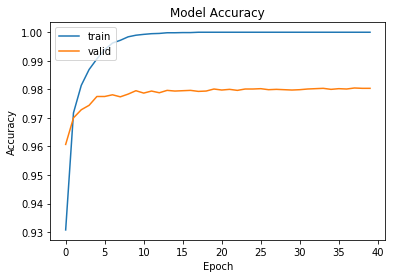

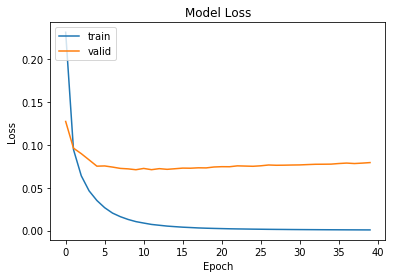

In [78]:
###Plot####
#print(history.history.keys())
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

#### <font color='blue'>Figure 6: Model Accuracy and Model Loss as a Function of the Number of Epochs</font>

Using Keras has again provided similar results to the Scikit-Learn API and the Tensorflow model, though this Keras model does seem to provide better accruacy when using the same hyperparameters.  While the increase in validation accuracy appears to result in an increased accuracy in the Kaggle competition as well, this may be due to the random nature of the DNN graph weights being initiated in each version of the model.

Keras has streamlined the use of Tensorflow, but kept most of the ability to customize the development of a DNN.  With this model, graphs showing the Model Accuracy and Model Loss with each epoch are displayed in Figure 6, helping to provide a visual of how the model is learning and then teaching itself in each epoch.

The predictions made using this model were submitted to Kaggle with the following results.    

Kaggle Submit Date: 3/26/2019

Kaggle Score: 0.97714

Kaggle Competition Rank: 1755

Kaggle User ID: GaryLawson.

## Conclusion

Deep neural networks are an amazing tool in the machine learning space that have revolutionized the ability for models to leverage data to learn how combinations of features impact the target response variable with little guidance from the data scientist.  In a lot of cases the result can be an increased level of target response predictions when compared to other machine learning methods.  

As seen with this example of handwritten digits, DNNs have a lot of promise and can be trained relatively quickly, and ulitimately provide terrific accuracy.  From a business standpoint, an experiment like this shows that DNNs can offer opportunities to help reduce costs through automation of image recognition and increase accuracy by limiting the amount of manual human interaction that is required to review such images.